In [1]:
"""
Code to test a variety of transverse field coupling constants and observe their 
effect on convergence accuracy.
"""

"""IMPORTS"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from qnade import autograd_hacks

Matplotlib is building the font cache; this may take a moment.


In [ ]:
def calculate_epsilons(model, s, psi_omega, B, J):
    """
    Calculates the E_loc(s) for all sampled states.
    epsilon(s) = sum(s_i * s_i+1) + B/psi_s * sum(psi_s_prime)

    Args:
        model: QNADE model
        s: sampled states matrix
        psi_omega: np list of wavefunction coefficients
        B: int, sigma_x activation
        J: int, sigma_z activation

    Returns:
        epsilon: double, epsilon contribution for the given state
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N = len(s[0])

    z_term = torch.zeros([len(s)]).to(device)

    # sum of the wavefunction coefficients resulting from sigma_x acting on each qubit (per sample)
    psi_s_prime_sum = torch.zeros([len(s)]).to(device)

    for i in range(N):

        if i == N - 1:
            z_term += s[:, 0] * s[:, i]
        else:
            z_term += s[:, i] * s[:, i + 1]

        # calculate the sum of psi_s_prime for the sigma_x term
        s_prime = s.clone()
        s_prime[:, i] = -1 * s_prime[:, i]
        psi_s_prime, _, _ = model(x=s_prime, requires_grad=False)
        psi_s_prime_sum += psi_s_prime

    x_term = psi_s_prime_sum / psi_omega

    epsilons = -(J * z_term + B * x_term)

    return epsilons


def calculate_expected_e(n, g):

    J = 1
    B = g

    # Initialize operators and Identity matrix
    s_z = np.array([[1, 0], [0, -1]])
    s_x = np.array([[0, 1], [1, 0]])
    I = np.array([[1, 0], [0, 1]])

    # Calculate and print energies for n qubits
    # print("\nQubits:", n)
    H = np.zeros((2**n, 2**n))
    H_ising = np.zeros((2**n, 2**n))
    H_tf = np.zeros((2**n, 2**n))

    # Generate and add Ising components to Hamiltonian
    for i in range(0, n):
        if i == 0 or i == n - 1:
            ising_comp = s_z
        else:
            ising_comp = I
        for j in range(0, n - 1):
            if j == i or j == i - 1:
                ising_comp = np.kron(ising_comp, s_z)
            else:
                ising_comp = np.kron(ising_comp, I)
        H_ising += ising_comp

    # Generate and add transverse components to Hamiltonian
    for i in range(0, n):
        if i == 0:
            trans_comp = s_x
        else:
            trans_comp = I
        for j in range(0, n - 1):
            if j == i - 1:
                trans_comp = np.kron(trans_comp, s_x)
            else:
                trans_comp = np.kron(trans_comp, I)
        H_tf += trans_comp

    H = -(J * H_ising + B * H_tf)

    return min(np.linalg.eigvals(H))

In [ ]:
class QNADE(nn.Module):  # takes a FFNN model as input

    def __init__(self, model):
        super(QNADE, self).__init__()

        self.model = model
        self.D = self.model[0].in_features  # input layer size
        self.M = self.model[-2].out_features  # output layer size
        self.evals = [0, 1]

    def forward(self, N_samples=None, x=None, requires_grad=True):

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if N_samples is None and x is None:
            raise ValueError(
                "Must enter samples or the number of samples to" " be generated"
            )

        # if not sampling, just calculating wavefunction
        if N_samples is None and x is not None:
            N_samples, need_samples = x.shape[0], False

        # if sampling and calculating wavefunction
        if N_samples is not None and x is None:
            need_samples = True
            x = torch.zeros([N_samples, self.D], dtype=torch.float).to(device)

        # the full wavefunction is a product of the conditionals
        WAV = torch.ones([N_samples]).to(device)
        order = np.arange(0, self.D)  # sequential autoregressive ordering

        # for gradient tracking
        params = list(self.parameters())
        grads_per_param = []

        for d in range(self.D):

            # mask enforces the autoregressive property
            mask = torch.zeros_like(x)
            mask[:, order[0:(d)]] = 1

            # add autograd hooks for per-sample gradient calculation
            if not hasattr(self.model, "autograd_hacks_hooks"):
                autograd_hacks.add_hooks(self.model)

            # L2 normalization of masked output
            out = F.normalize(self.model(mask * x), 2)

            # 'psi_pos' is positive bits, 'psi_neg' is negative bits
            psi_pos = out[:, 0].squeeze()
            psi_neg = out[:, 1].squeeze()

            if need_samples == True:

                # sampling routine according to psi**2:
                # convert bit values from 0 to -1
                m = torch.distributions.Bernoulli(psi_pos**2).sample()
                m = torch.where(m == 0, -1, 1)

                # update sample tensor
                x[:, d] = m

                # Accumulate PSI based on which state (s) was sampled
                selected_wavs = torch.where(x[:, d] > 0, psi_pos, psi_neg)
                WAV = WAV * selected_wavs

            else:

                # if not sampling, m is a list of bits in column d
                m = x[:, d]

                # Accumulate PPSI based on which state (s) was sampled
                selected_wavs = torch.where(m > 0, psi_pos, psi_neg)
                WAV = WAV * selected_wavs

            if requires_grad == True:

                # eval_grads stores backpropagation values for out1 and out2.
                # eval_grads[0] are the out1 grads for all samples (per param),
                # eval_grads[1] are the out2 grads for all samples (per param).
                eval_grads = [[[]] * len(params) for outputs in range(len(self.evals))]

                # Store the per-output grads in eval_grads
                for output in range(len(self.evals)):

                    # backpropagate the current output (out1 or out2)
                    out[:, output].mean(0).backward(retain_graph=True)

                    # compute gradients for all samples
                    autograd_hacks.compute_grad1(self.model)
                    autograd_hacks.clear_backprops(self.model)

                    # store the calculated gradients for all samples
                    for param in range(len(params)):
                        eval_grads[output][param] = params[param].grad1

                # allocate space for gradient accumulation
                if d == 0:
                    for param in range(len(params)):
                        grads_per_param.append(torch.zeros_like(eval_grads[0][param]))

                # accumulate gradients per parameter based on sampled bits
                for param in range(len(params)):

                    # reshape m and wavs so they can be accumulated/divided properly
                    reshaped_m = m.reshape(
                        m.shape + (1,) * (grads_per_param[param].ndim - 1)
                    )
                    reshaped_wavs = selected_wavs.reshape(
                        selected_wavs.shape + (1,) * (grads_per_param[param].ndim - 1)
                    )

                    # select the proper gradient to accumulate based on m
                    grads_per_param[param][:] += torch.where(
                        reshaped_m[:] > 0,
                        eval_grads[0][param][:] / reshaped_wavs[:],
                        eval_grads[1][param][:] / reshaped_wavs[:],
                    )

        return WAV.detach(), x.detach(), grads_per_param

In [ ]:
"""OPTIMIZATION LOOP"""


def train(B_vals, num_qubits, learning_rate):

    # define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    energies_per_g = []

    for trial in range(len(B_vals)):

        # number of qubits
        L = num_qubits
        H = 2 * L

        J = 1  # sigma_z activation
        B = B_vals[trial]  # sigma_x activation

        # initialize network and model, put network on device
        network = nn.Sequential(
            nn.Linear(L, H),
            nn.Tanh(),
            nn.Linear(H, 2 * H),
            nn.Tanh(),
            nn.Linear(2 * H, 2),
            nn.Tanh(),
        )
        network.to(device)
        model = QNADE(network)
        params = list(model.parameters())

        # Training hyperparameters
        iters = 100
        batch_size = 10000
        lr = learning_rate

        # initialize optimizer
        optimizer = torch.optim.Adam(params=network.parameters(), lr=lr)
        optimizer.zero_grad()

        # training loop
        energies = []
        for iter in range(iters):

            if iter % 10 == 0:
                print("iter: {}".format(iter))

            # generate data
            psi_omega, samples, grads_per_param = model(N_samples=batch_size)

            # calculate local energies
            epsilons = calculate_epsilons(model, samples, psi_omega, B, J).to(device)

            # E is an average of local energies
            E = epsilons.mean()
            energies.append(E)
            epsilons -= E

            # calculate O_k for a given parameter and number of samples
            for param in range(len(params)):

                # define O_k for a set of parameters
                O_k = grads_per_param[param].detach()

                # weight O_k according to epsilons
                O_k *= epsilons.reshape(epsilons.shape + (1,) * (O_k.ndim - 1))

                # e_grad is an average of all O_k_s
                e_grad = torch.mean(O_k, 0, keepdim=True).squeeze()

                # update network parameter matrix with energy gradient
                with torch.no_grad():
                    params[param].grad.copy_(e_grad)

            # optimize network based on e_grad
            optimizer.step()

        final_energy = min(energies)

        energies_per_g.append(float(final_energy))

        # plot training data
        print("\n")
        plt.figure()
        if L > 10:
            expected_e = 0
        else:
            expected_e = calculate_expected_e(L, B)
        expected_e_plot = [expected_e for i in range(iters)]
        plt.title(
            "trial={}; L={}; g={}; E_calc={}; E_exp={};".format(
                trial, L, B, final_energy, expected_e
            )
        )
        plt.plot(energies)
        plt.plot(expected_e_plot, "g--")
        plt.xlabel("Iterations")
        plt.ylabel("Energy")
        # plt.savefig("{}_spins_B={}_trial{}.png".format(L,B,trial))
        plt.show()

    print(min(energies_per_g), energies_per_g.index(min(energies_per_g)))

    return min(energies_per_g), energies_per_g.index(min(energies_per_g))

In [ ]:
L = 10
lr = 0.01

B_vals = [
    [0.1, 0.1, 0.1, 0.1, 0.1],
    [0.2, 0.2, 0.2, 0.2, 0.2],
    [0.3, 0.3, 0.3, 0.3, 0.3],
    [0.4, 0.4, 0.4, 0.4, 0.4],
    [0.5, 0.5, 0.5, 0.5, 0.5],
    [0.6, 0.6, 0.6, 0.6, 0.6],
    [0.7, 0.7, 0.7, 0.7, 0.7],
    [0.8, 0.8, 0.8, 0.8, 0.8],
    [0.9, 0.9, 0.9, 0.9, 0.9],
    [1.0, 1.0, 1.0, 1.0, 1.0],
    [1.1, 1.1, 1.1, 1.1, 1.1],
    [1.2, 1.2, 1.2, 1.2, 1.2],
    [1.3, 1.3, 1.3, 1.3, 1.3],
    [1.4, 1.4, 1.4, 1.4, 1.4],
    [1.5, 1.5, 1.5, 1.5, 1.5],
    [1.6, 1.6, 1.6, 1.6, 1.6],
    [1.7, 1.7, 1.7, 1.7, 1.7],
    [1.8, 1.8, 1.8, 1.8, 1.8],
    [1.9, 1.9, 1.9, 1.9, 1.9],
    [2.0, 2.0, 2.0, 2.0, 2.0],
]

# B_vals = [[1.5, 1.5, 1.5, 1.5, 1.5]]

iter: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




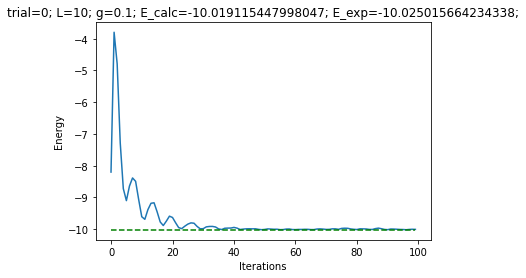

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




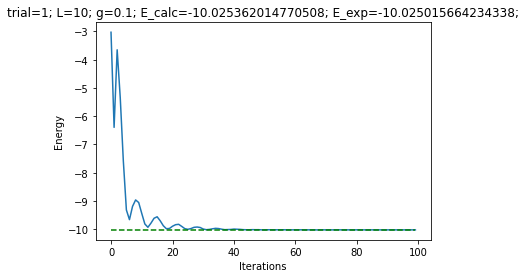

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




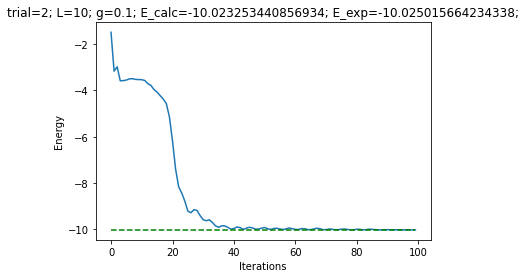

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




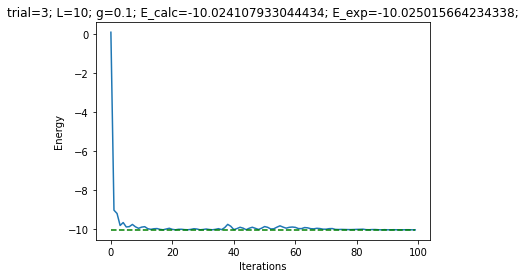

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




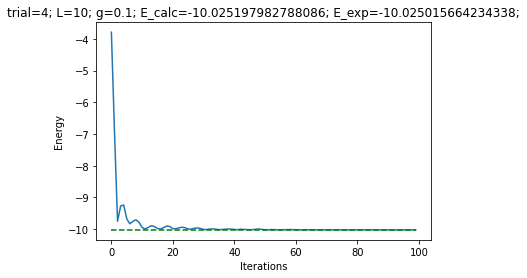

-10.025362014770508 1
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




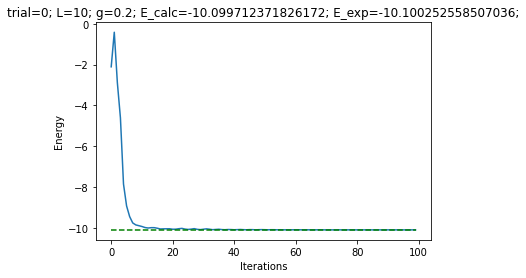

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




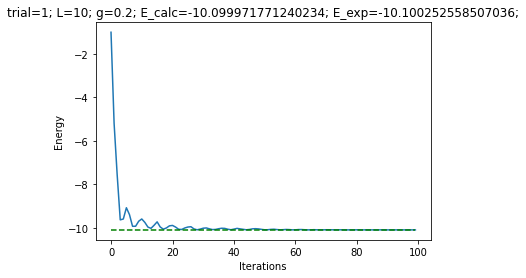

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




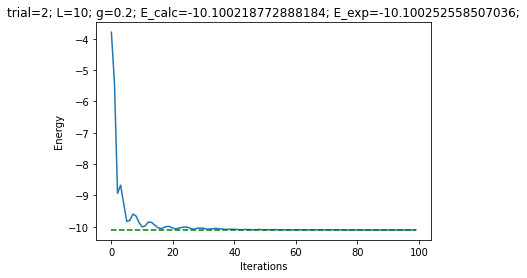

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




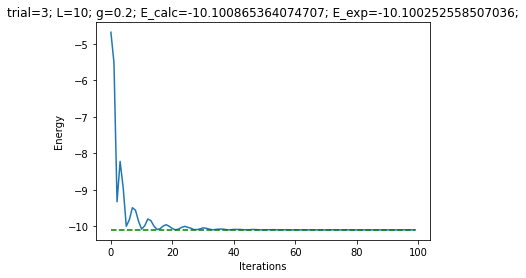

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




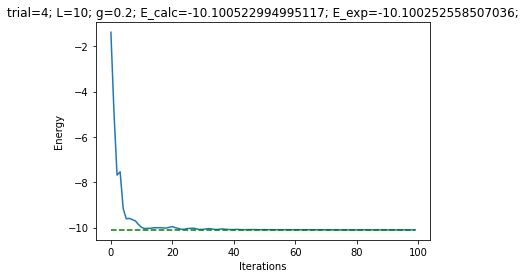

-10.100865364074707 3
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




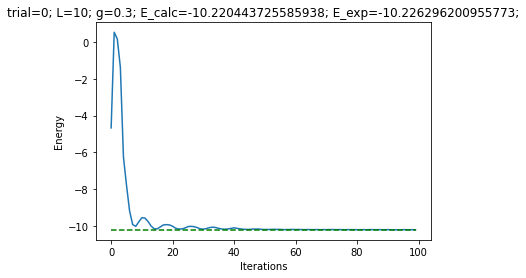

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




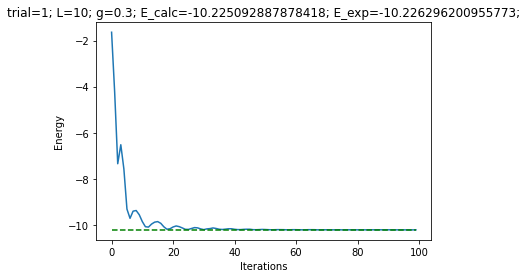

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




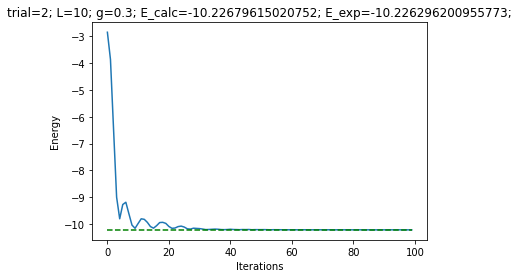

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




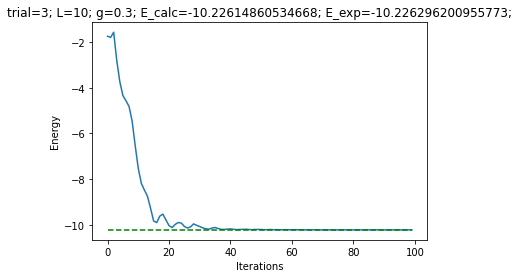

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




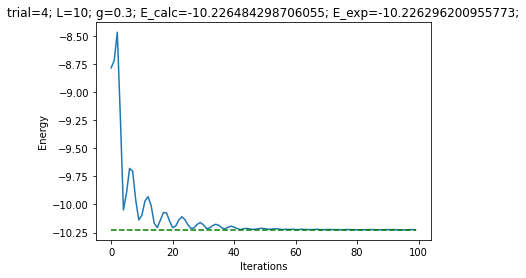

-10.22679615020752 2
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


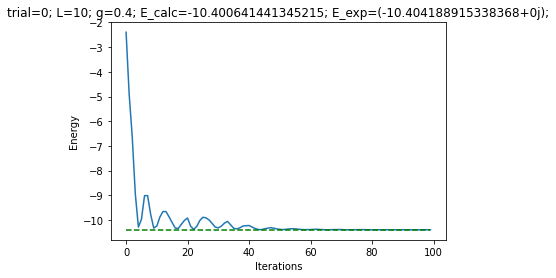

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




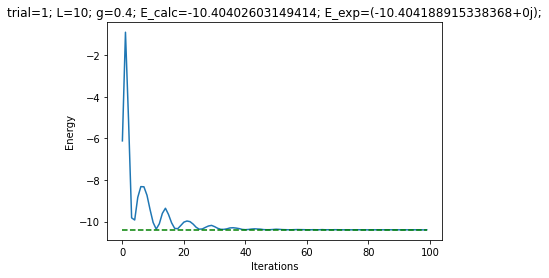

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




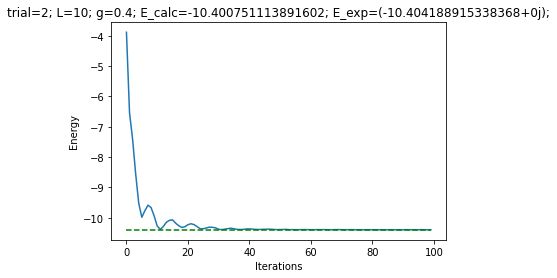

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




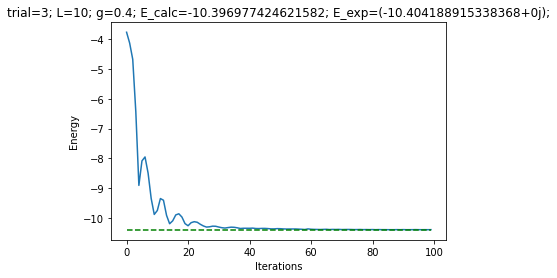

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




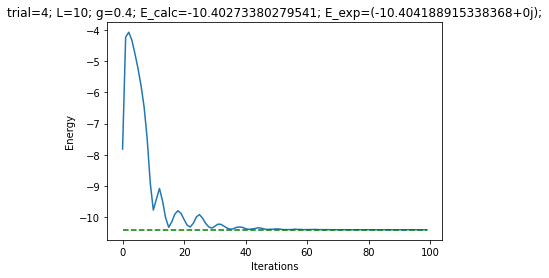

-10.40402603149414 1
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




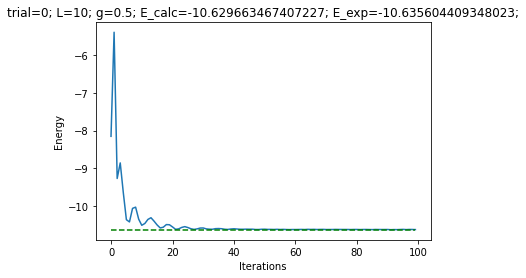

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




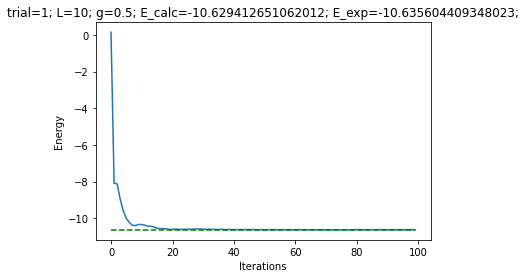

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




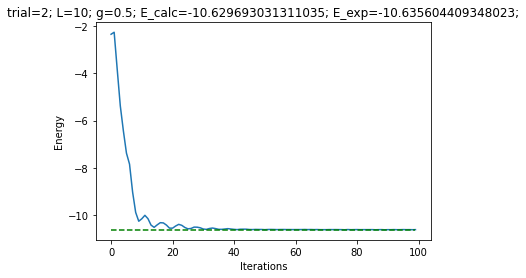

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




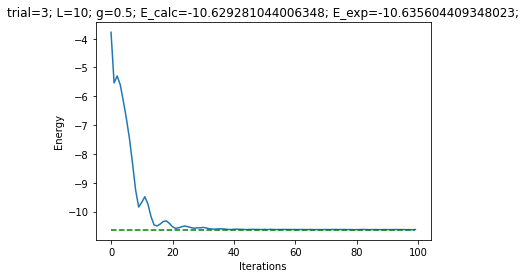

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




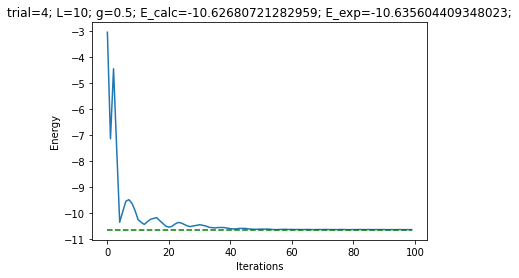

-10.629693031311035 2
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




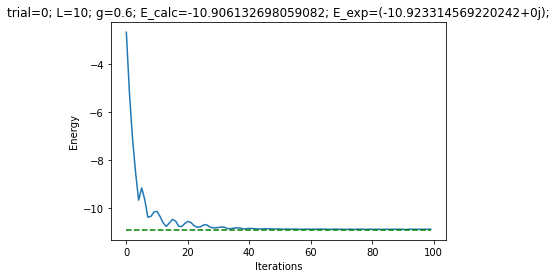

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




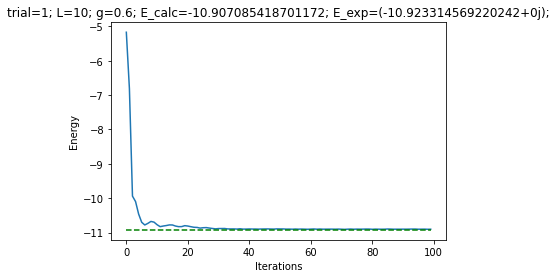

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




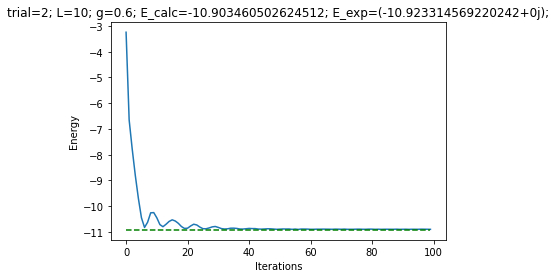

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




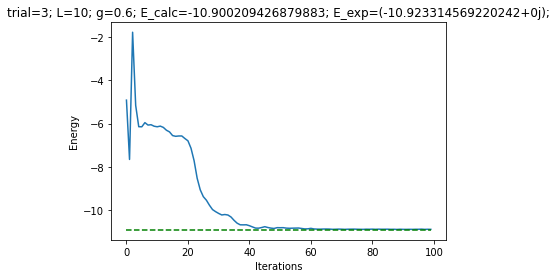

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




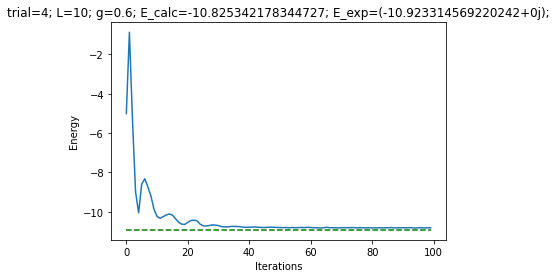

-10.907085418701172 1
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




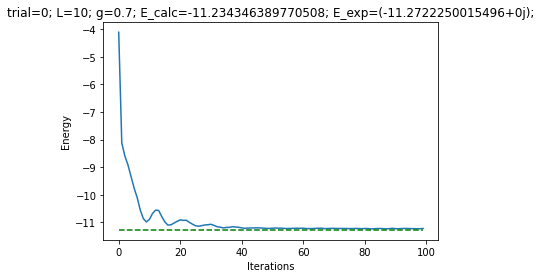

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




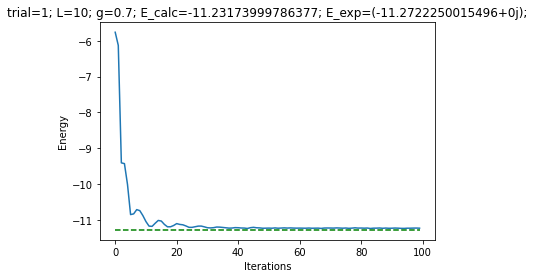

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




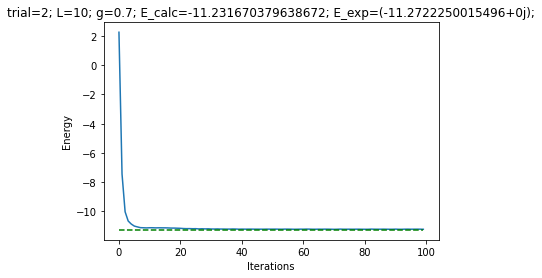

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




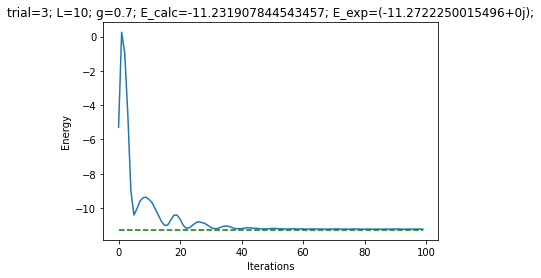

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




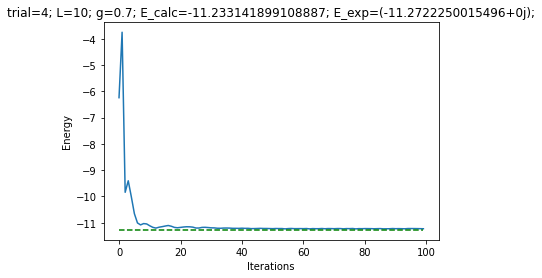

-11.234346389770508 0
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




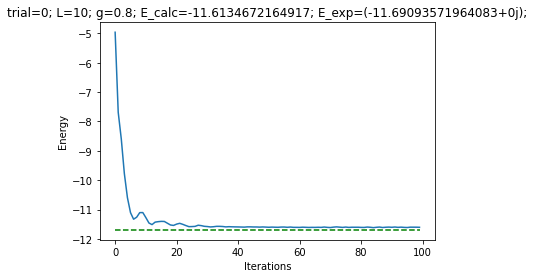

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




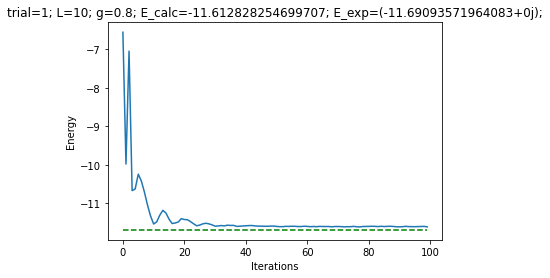

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




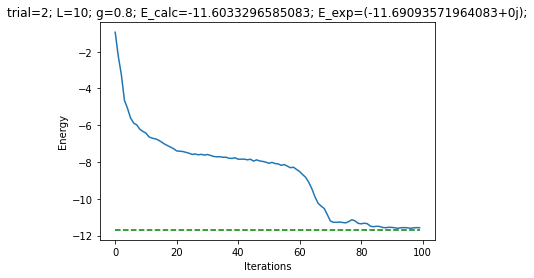

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




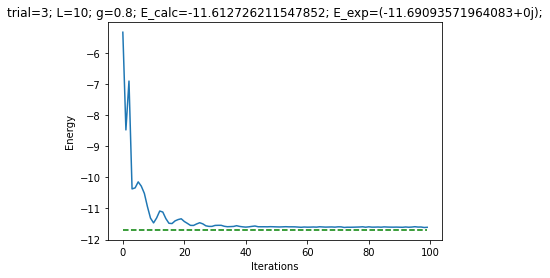

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




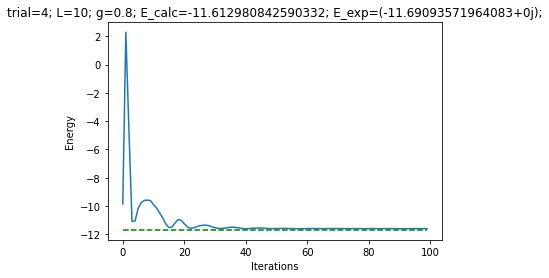

-11.6134672164917 0
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




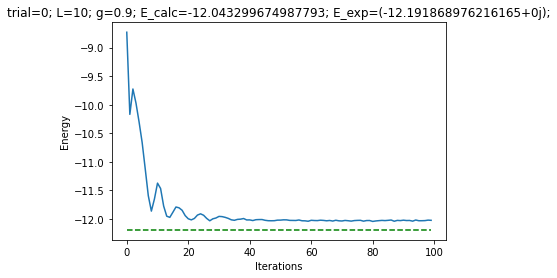

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




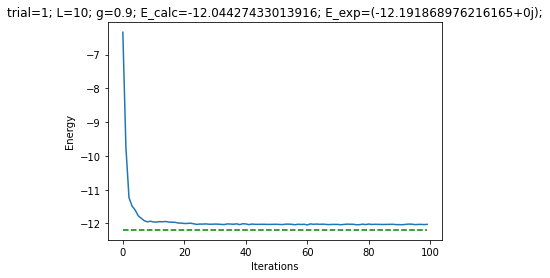

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




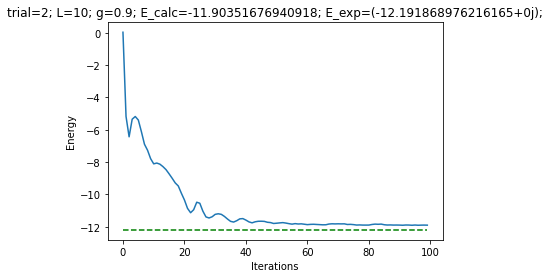

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




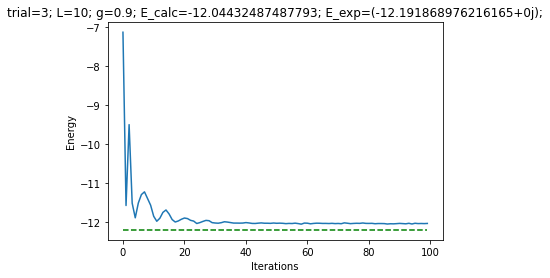

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




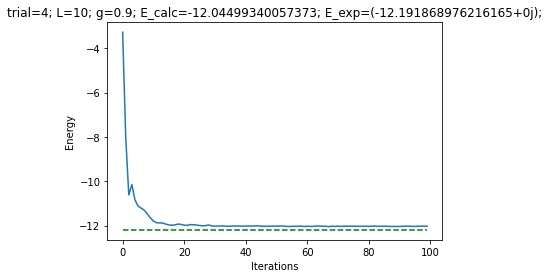

-12.04499340057373 4
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




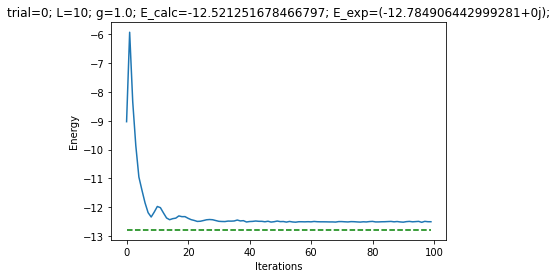

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




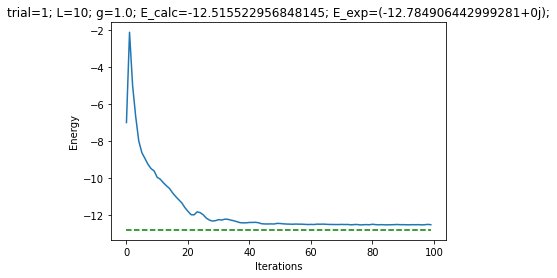

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




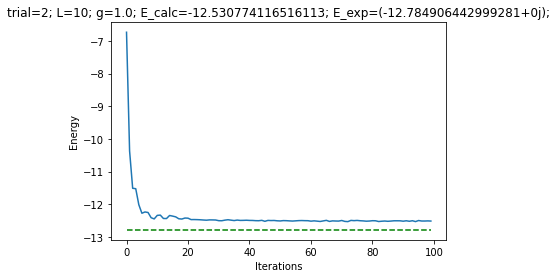

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




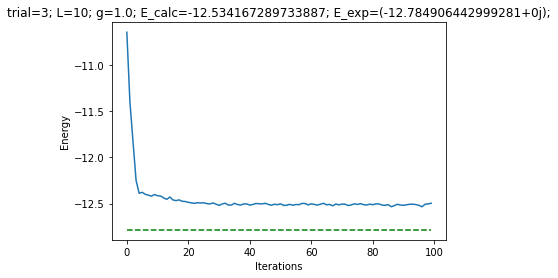

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




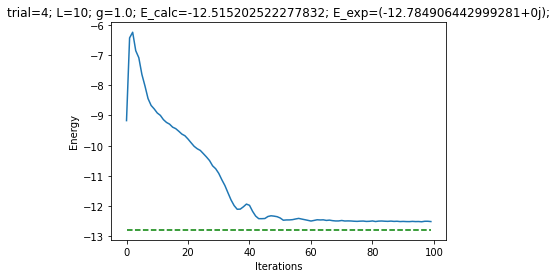

-12.534167289733887 3
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




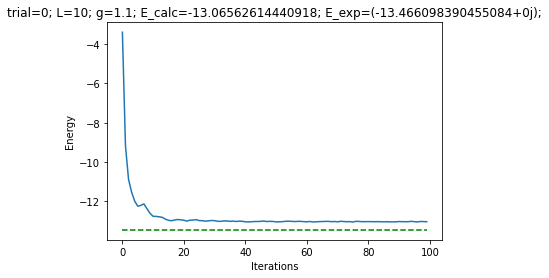

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




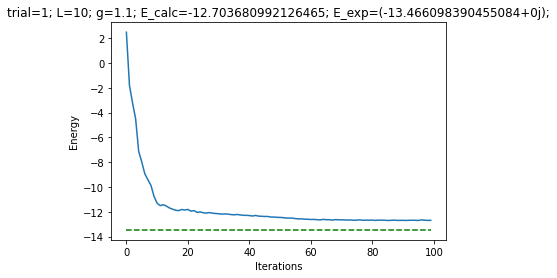

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




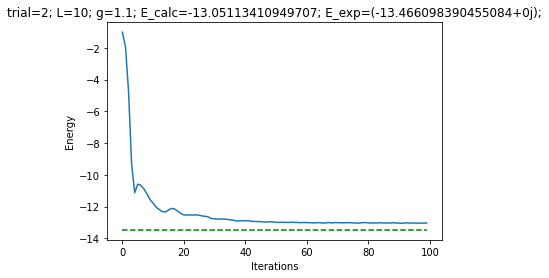

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




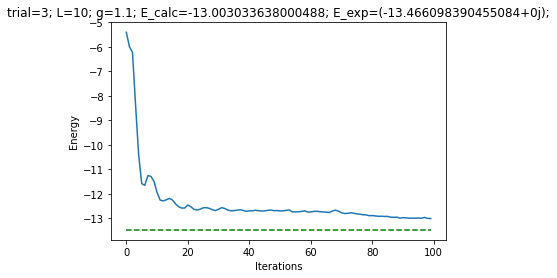

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




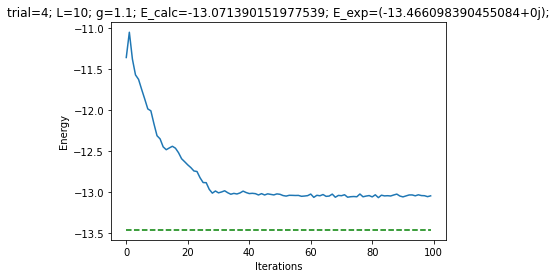

-13.071390151977539 4
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




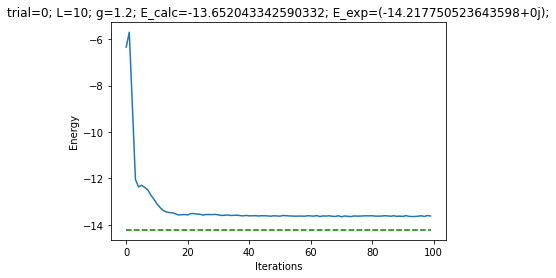

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




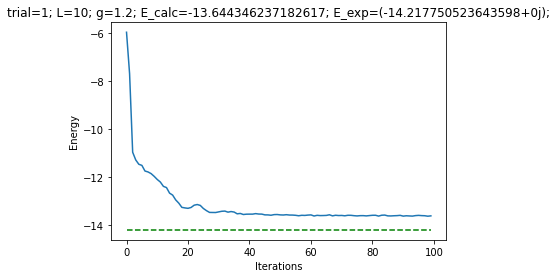

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




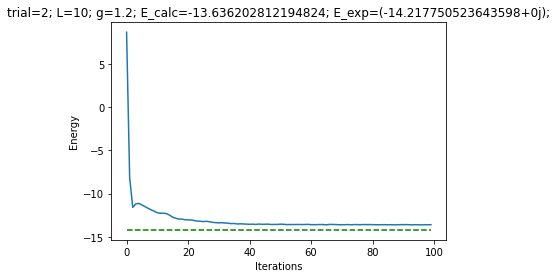

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




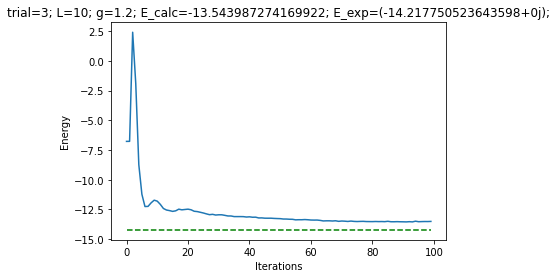

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




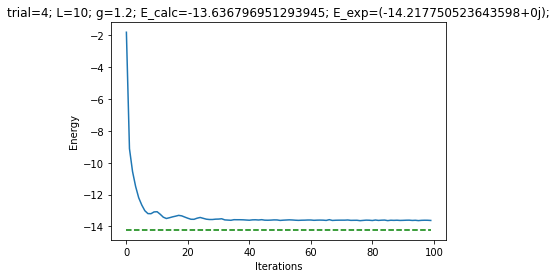

-13.652043342590332 0
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




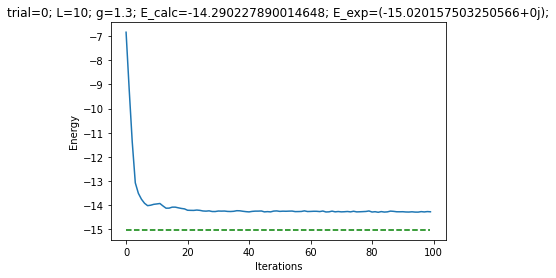

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




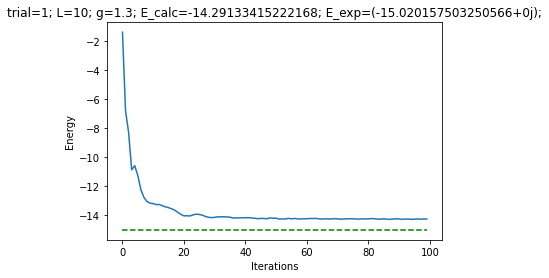

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




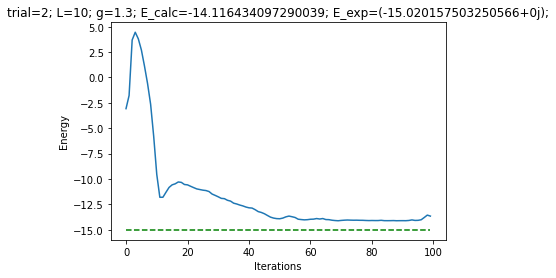

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




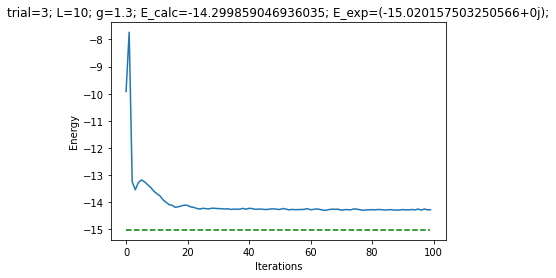

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




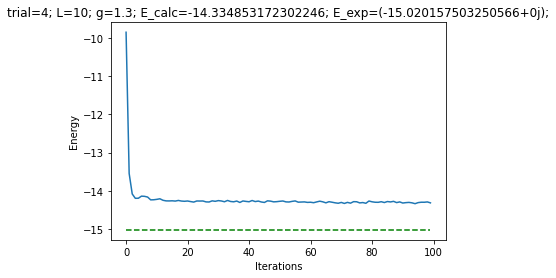

-14.334853172302246 4
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




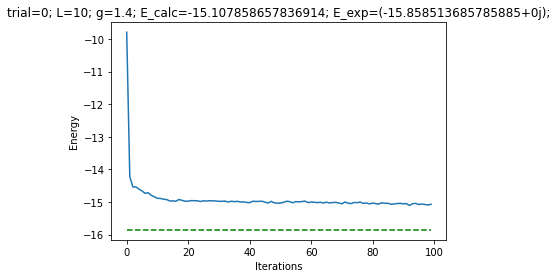

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




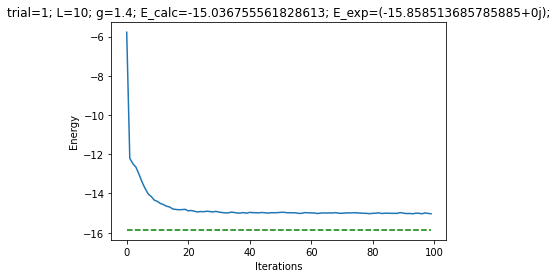

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




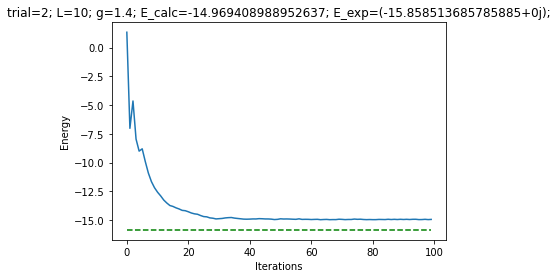

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




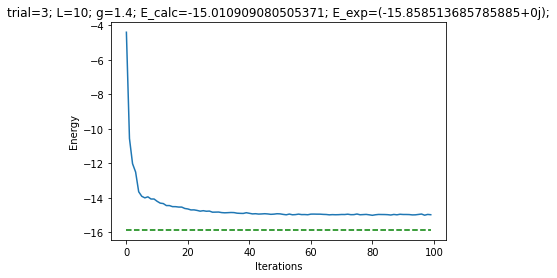

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




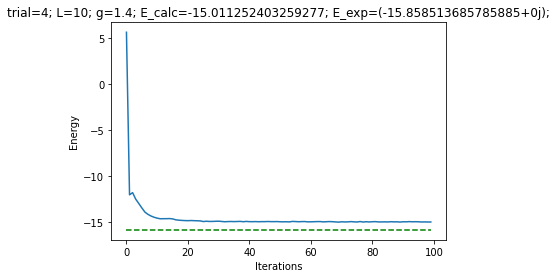

-15.107858657836914 0
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




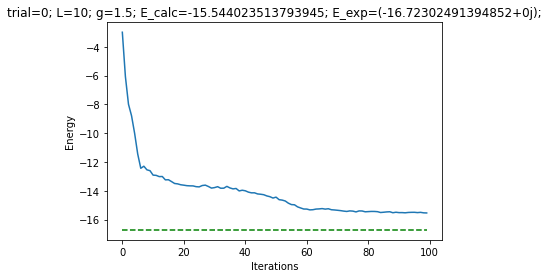

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




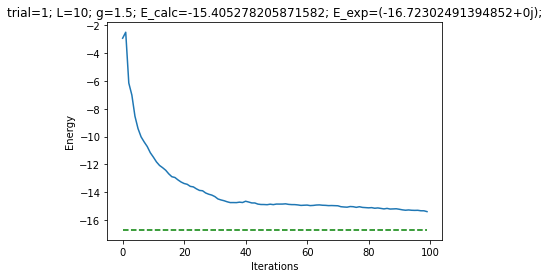

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




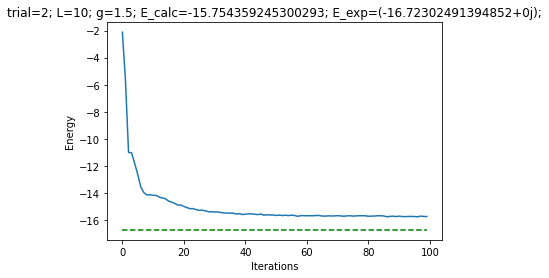

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




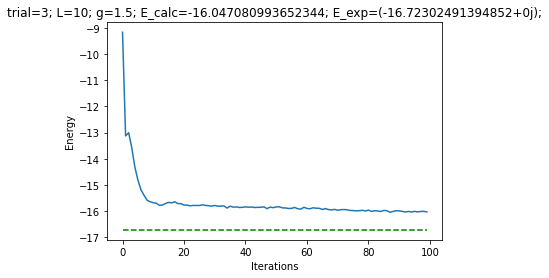

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




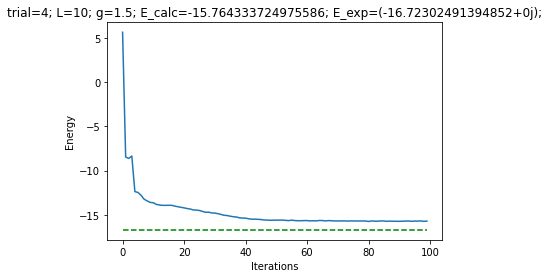

-16.047080993652344 3
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




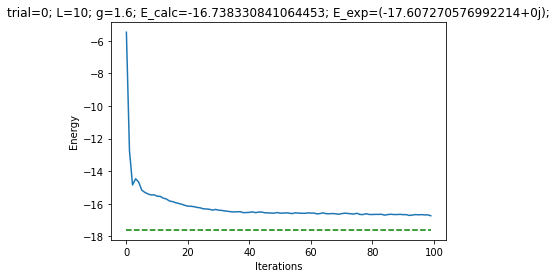

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




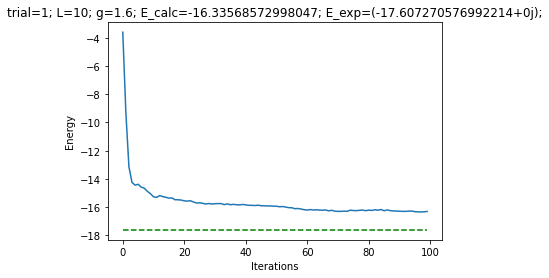

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




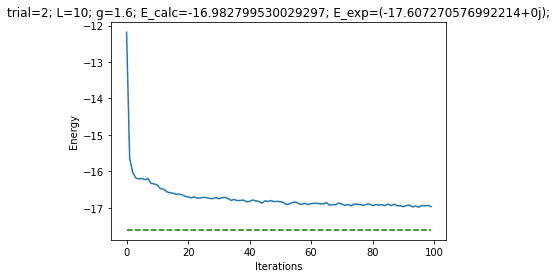

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




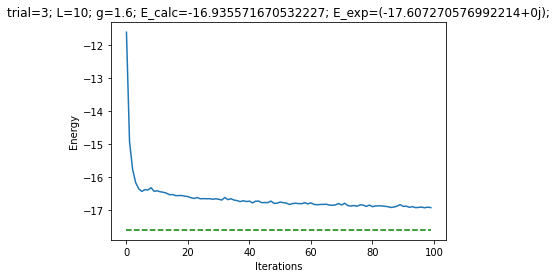

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




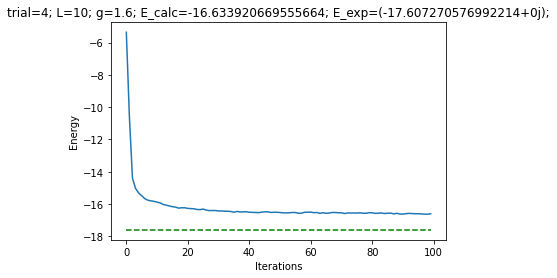

-16.982799530029297 2
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




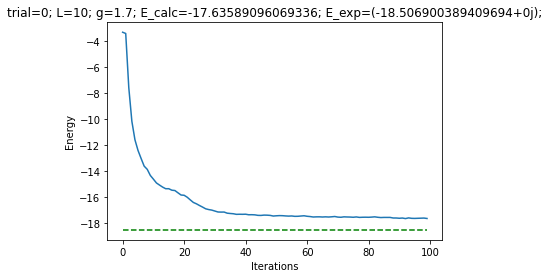

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




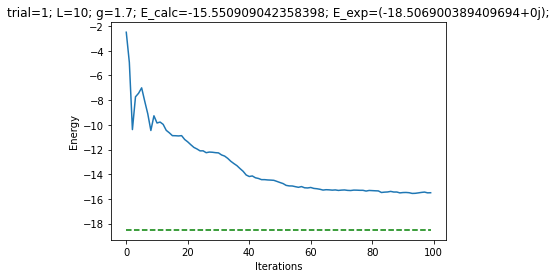

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




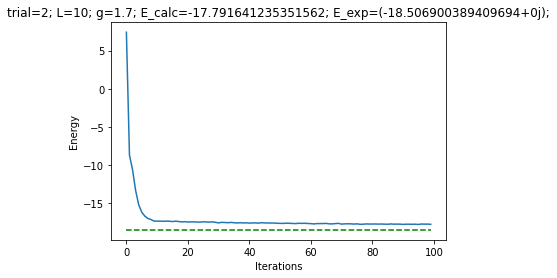

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




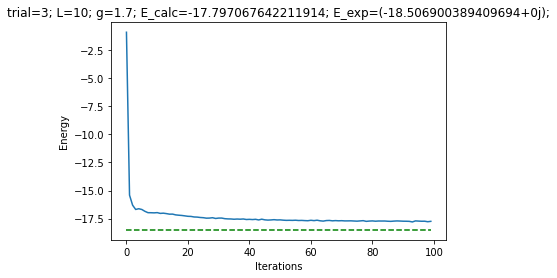

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




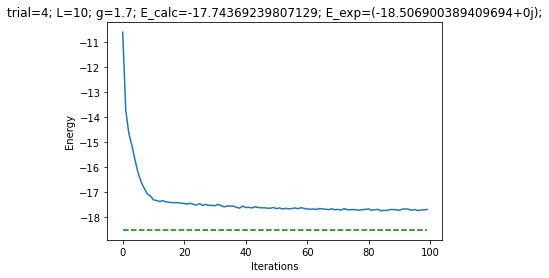

-17.797067642211914 3
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




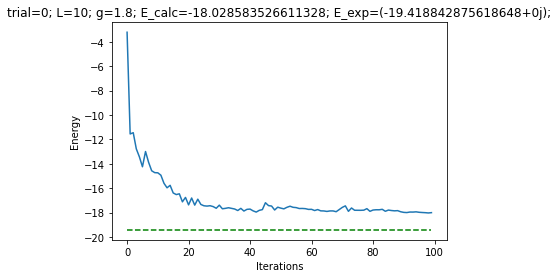

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




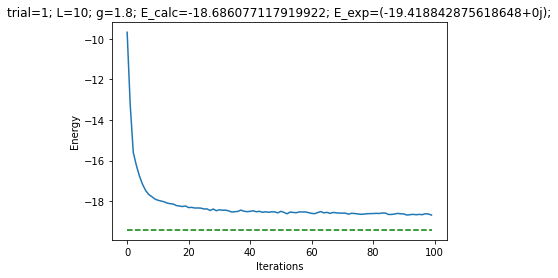

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




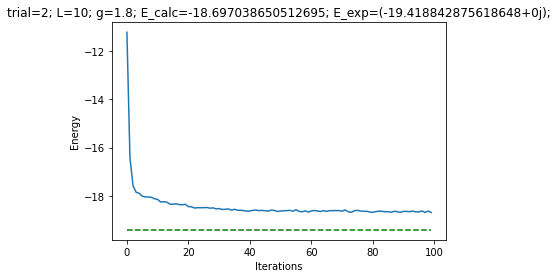

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




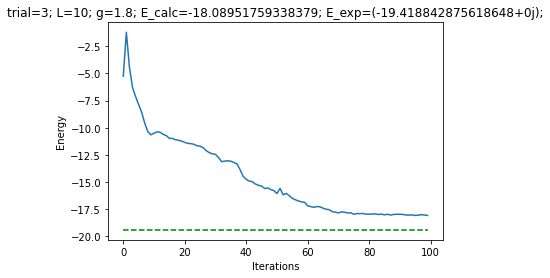

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




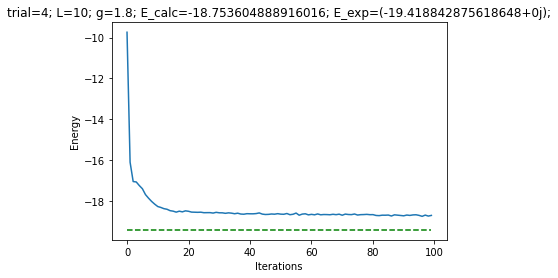

-18.753604888916016 4
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




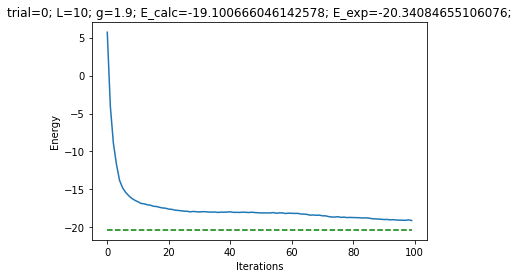

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




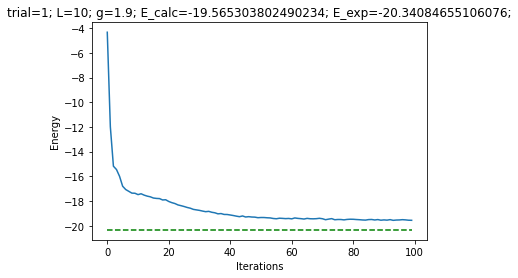

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




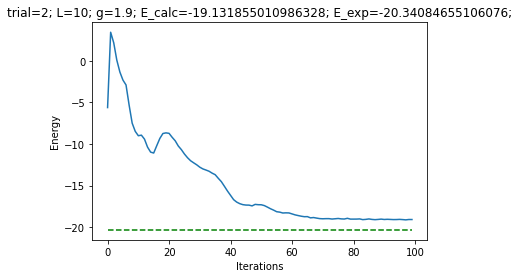

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




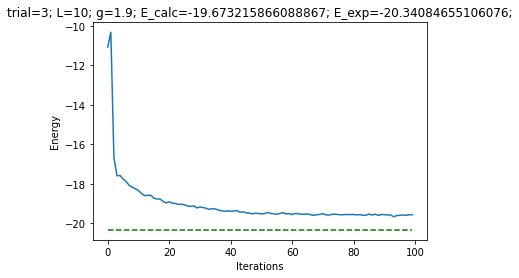

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




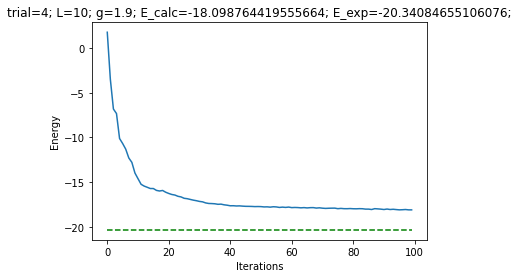

-19.673215866088867 3
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




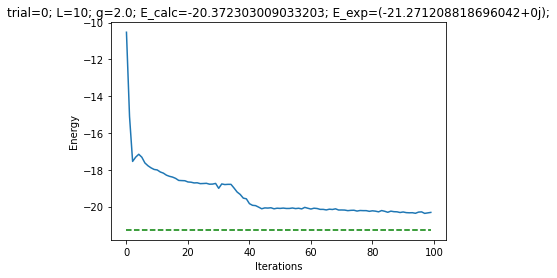

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




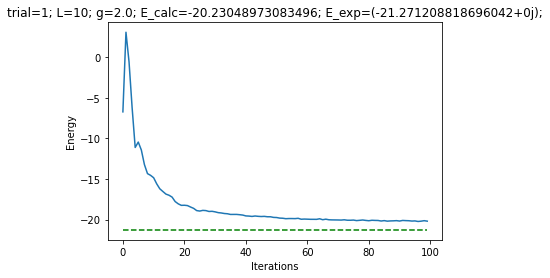

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




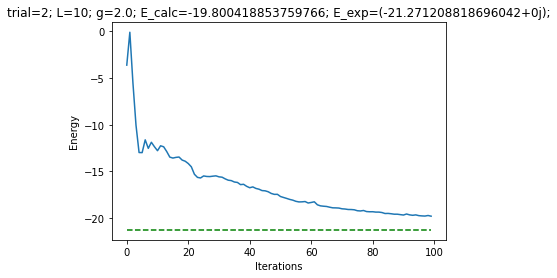

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




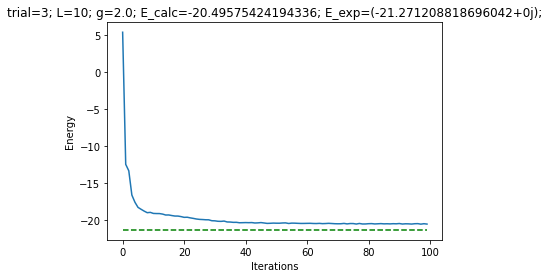

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90




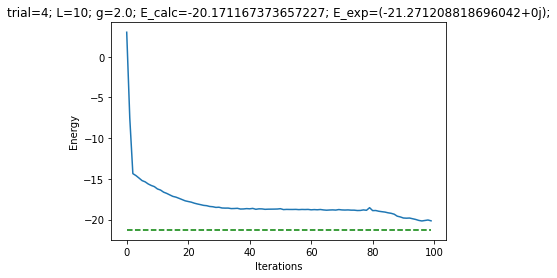

-20.49575424194336 3


In [ ]:
"""DATA GENERATION"""

min_e_train = []
for val_set in B_vals:
    min_e_train.append(train(val_set, L, lr)[0])

In [ ]:
tested_b_vals = [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1.0,
    1.1,
    1.2,
    1.3,
    1.4,
    1.5,
    1.6,
    1.7,
    1.8,
    1.9,
    2.0,
]

# generate expected ground state energies
min_e_exp = [calculate_expected_e(L, g).real for g in tested_b_vals]

print(min_e_train)
print(min_e_exp)

[-10.025362014770508, -10.100865364074707, -10.22679615020752, -10.40402603149414, -10.629693031311035, -10.907085418701172, -11.234346389770508, -11.6134672164917, -12.04499340057373, -12.534167289733887, -13.071390151977539, -13.652043342590332, -14.334853172302246, -15.107858657836914, -16.047080993652344, -16.982799530029297, -17.797067642211914, -18.753604888916016, -19.673215866088867, -20.49575424194336]
[-10.025015664234338, -10.100252558507036, -10.226296200955773, -10.404188915338368, -10.635604409348023, -10.923314569220242, -11.2722250015496, -11.69093571964083, -12.191868976216165, -12.784906442999281, -13.466098390455084, -14.217750523643598, -15.020157503250566, -15.858513685785885, -16.72302491394852, -17.607270576992214, -18.506900389409694, -19.418842875618648, -20.34084655106076, -21.271208818696042]


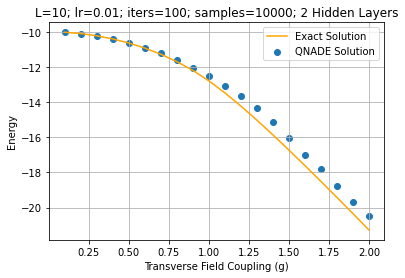

In [ ]:
"""PLOT DATA"""

plt.scatter(tested_b_vals, min_e_train, label="QNADE Solution")
plt.plot(tested_b_vals, min_e_exp, "orange", label="Exact Solution")
plt.grid()
plt.legend()
plt.xlabel("Transverse Field Coupling (g)")
plt.ylabel("Energy")
plt.title("L=10; lr=0.01; iters=100; samples=10000; 2 Hidden Layers")
plt.savefig("g_test_2_H_Layer_L=10.png")
plt.show()